# Web-Scraping & Crawling
In diesem Notebook wird folgendes gemacht:
* Mit einem Scraper werden die XML-Datein ausgelesen
* Mit einem Crawler werden die Daten aus den URLs extrahiert

## Allgemeines Setup des Notebooks

In [1]:
%run "../lib/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Imports

In [2]:
import requests
from bs4 import BeautifulSoup

# Lesen der robots.txt
Durch die ``robots.txt`` kann man auslesen, welche Inhalte von Websites "gecrawled" werden dürfen und welche nicht. Die URL die uns interessiert - ``/services/opendata`` - ist nicht aufgelistet und kann entsprechend von uns ausgelesen werden.

In [3]:
url = "https://www.bundestag.de/robots.txt"
response = requests.get(url)
print(response.text)

User-agent: *
Disallow: /includes/
Allow: /includes/images/mediathek/
Disallow: /WEB-INF/
Disallow: /blueprint/WEB-INF
Disallow: /xml/
Disallow: /service/quiz/
Disallow: /apps/
Disallow: /static/wfa_20wp
Disallow: /resource/blob/834414/




## Soup Objekt erstellen
Mit ``BeautifulSoup`` lassen sich sehr einfach Objekte aus XML oder HTML Dokumenten erstellen, die man dann wie jedes andere Objekt nutzen kann, was das Auslesen vereinfacht.

In [4]:
url = "https://www.bundestag.de/resource/blob/839934/792f4d01c3df4519a974e3ea9ba8132f/19226-data.xml"

response = requests.get(url)
soup = BeautifulSoup(response.content, "lxml")

Die XML-Dateien sind ziemlich groß und komplex. Wir werden zunächst die Metadaten aus dem Tag ``dbtplenarprotokoll`` (also dem root-Element) extrahieren.

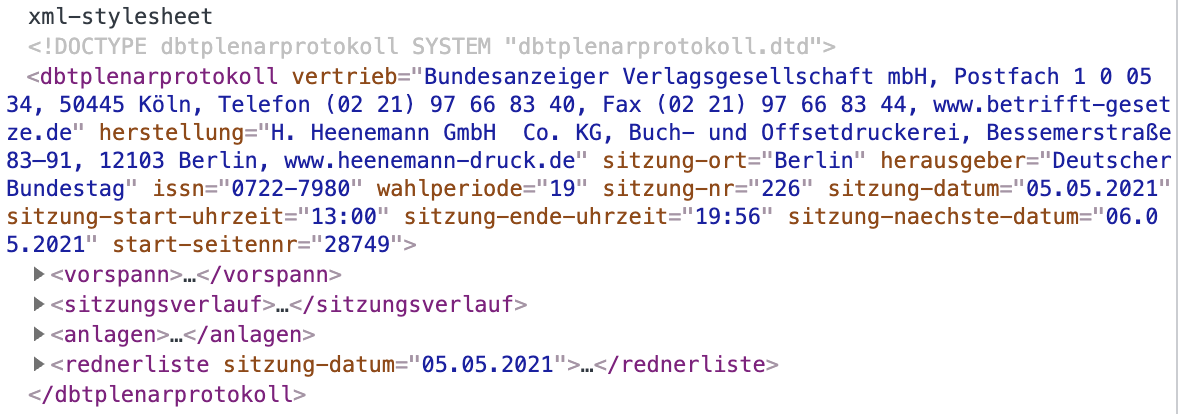

### Extraktion der Metadaten

In [8]:
soup.find('dbtplenarprotokoll').attrs

{'vertrieb': 'Bundesanzeiger Verlagsgesellschaft mbH, Postfach 1 0 05 34, 50445 Köln, Telefon (02 21) 97 66 83 40, Fax (02 21) 97 66 83 44, www.betrifft-gesetze.de',
 'herstellung': 'H. Heenemann GmbH  Co. KG, Buch- und Offsetdruckerei, Bessemerstraße 83–91, 12103 Berlin, www.heenemann-druck.de',
 'sitzung-ort': 'Berlin',
 'herausgeber': 'Deutscher Bundestag',
 'issn': '0722-7980',
 'wahlperiode': '19',
 'sitzung-nr': '226',
 'sitzung-datum': '05.05.2021',
 'sitzung-start-uhrzeit': '13:00',
 'sitzung-ende-uhrzeit': '19:56',
 'sitzung-naechste-datum': '06.05.2021',
 'start-seitennr': '28749'}

### Extraktion der Redensdaten
Die Daten, die uns interessieren, sind die Reden in einer Sitzung des Bundestags. Wo diese zu finden sind, sehen wir in folgendem Bild.

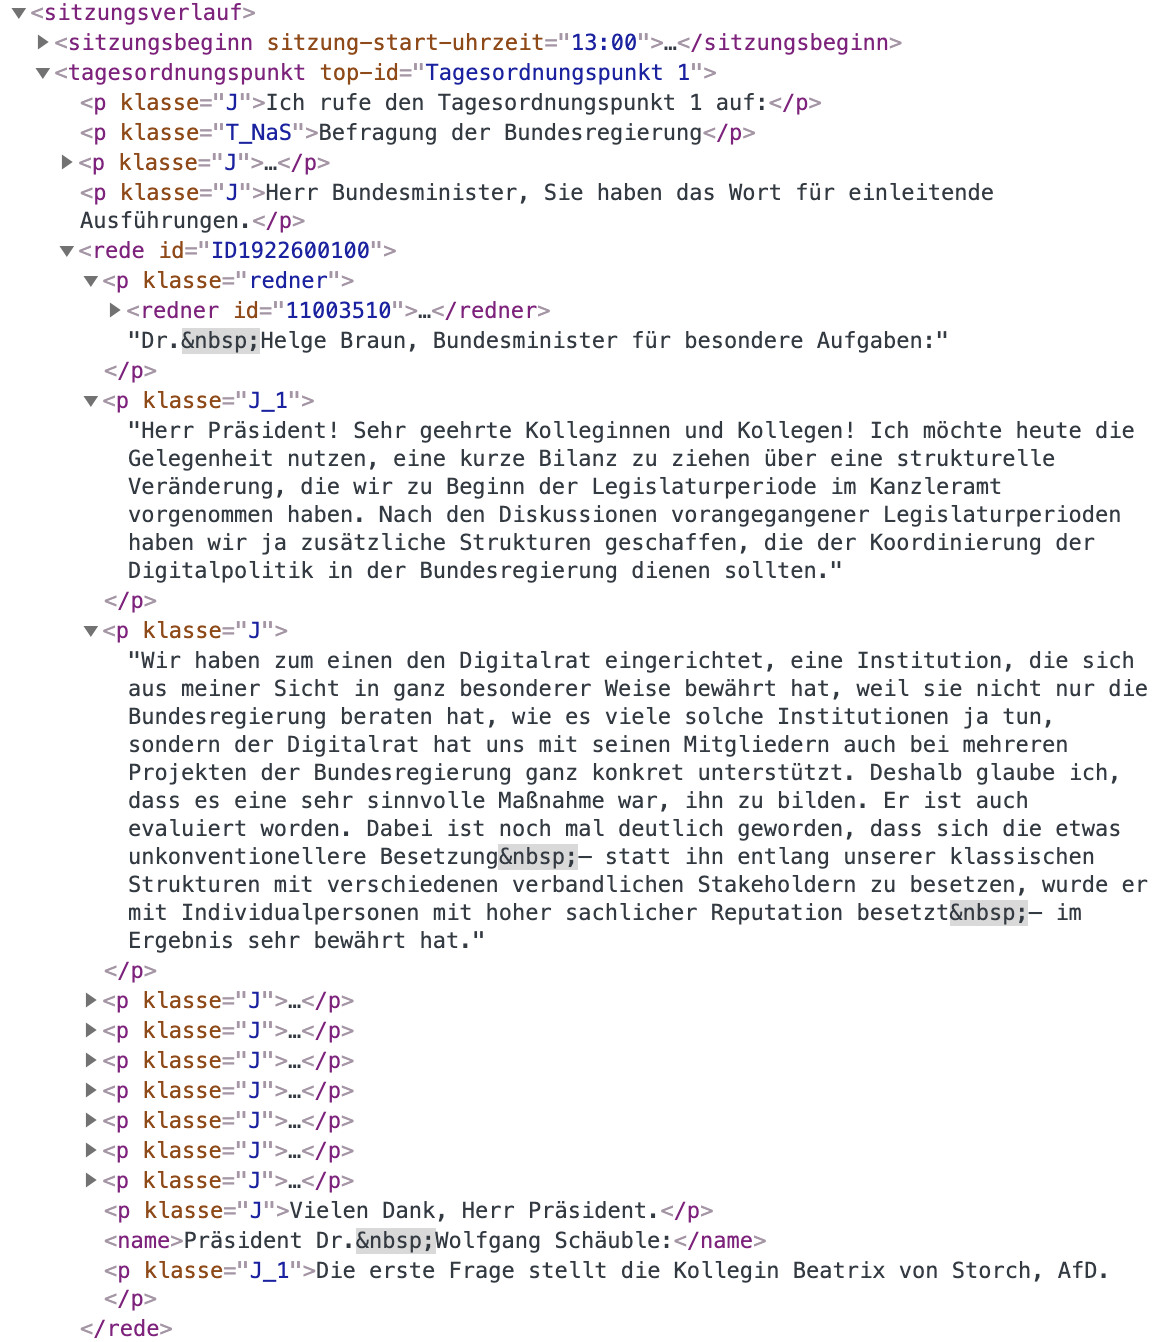

Wir sehen außerdem andere wichtige Elemente, die uns interessieren. Wir sehen, dass sowohl die Reden selbst, als auch die Redner jeweils eine eigene ID haben. Außerdem sehen wir, wo die Rede zu finden ist. Diese befindet sich in p-Tags, die die Klasse "J_1" oder "J" haben. Dies werden wir uns später zu Nutzen machen.

In [9]:
reden = soup.find_all('rede')

bsp_rede = reden[0]
bsp_rede

<rede id="ID1922600100">
<p klasse="redner">
<redner id="11003510">
<name>
<titel>Dr.</titel>
<vorname>Helge</vorname>
<nachname>Braun</nachname>
<rolle>
<rolle_lang>Bundesminister für besondere Aufgaben</rolle_lang>
<rolle_kurz>Bundesminister für besondere Aufgaben</rolle_kurz>
</rolle>
</name>
</redner>Dr. Helge Braun, Bundesminister für besondere Aufgaben:</p>
<p klasse="J_1">Herr Präsident! Sehr geehrte Kolleginnen und Kollegen! Ich möchte heute die Gelegenheit nutzen, eine kurze Bilanz zu ziehen über eine strukturelle Veränderung, die wir zu Beginn der Legislaturperiode im Kanzleramt vorgenommen haben. Nach den Diskussionen vorangegangener Legislaturperioden haben wir ja zusätzliche Strukturen geschaffen, die der Koordinierung der Digitalpolitik in der Bundesregierung dienen sollten.</p>
<p klasse="J">Wir haben zum einen den Digitalrat eingerichtet, eine Institution, die sich aus meiner Sicht in ganz besonderer Weise bewährt hat, weil sie nicht nur die Bundesregierung beraten hat,

Hier sehen wir mal ein Beispiel einer Rede aus dem Soup-Objekt. 

# Protokoll Scraper
Hier bauen wir uns jetzt den Scraper, der die Protokolle der Sitzungen in eine Liste von Dictionaries packt, mit denen wir später den Dataframe bauen können.

In [99]:
from bs4 import BeautifulSoup
import traceback
import re

def dbt_protocol_scraper(xml):
    '''
    Scrapes text and metadata from speeches of Deutscher Bundestag Plenarprotokoll (XML).
    
    Returns a list of dictionaries.
    
    [
        {
            speech_id,
            speaker,
            affiliation,
            text,
            session_id, 
            session_date, 
            session_start,
            session_end,
            legislative_period
        },
        ...
    ]
    '''
    
    try:
        soup = BeautifulSoup(xml, 'lxml')
    
        # Meta data from the root tag 'dbtplenarprotokoll'
        dbt_pp = soup.find('dbtplenarprotokoll')
        
        session_id_ = dbt_pp['sitzung-nr']
        session_date_ = dbt_pp['sitzung-datum']
        session_start_ = dbt_pp['sitzung-start-uhrzeit']
        session_end_ = dbt_pp['sitzung-ende-uhrzeit']
        legislative_period_ = dbt_pp['wahlperiode']
        
        # Scraping all the speeches from particular session
        speeches = dbt_pp.find_all('rede')
        scraped_speeches = []
        
        for speech in speeches:
            speech_id_ = speech['id']
            
            # leaving out titles, functions and 
            name_tag = speech.redner.select_one('name')
            speaker_ = ''
            
            try:
                speaker_ = ' '.join([name_tag.vorname.text.strip(), name_tag.nachname.text.strip()])
            except Exception:
                s = speech.find('p', {'klasse': 'redner'}).contents[-1]
                speaker_ = re.findall(r'\w{2,}\s\w+', s)[0]
            
            affiliation_tag = name_tag.fraktion if name_tag.fraktion is not None else name_tag.rolle.rolle_kurz
            affiliation_ = affiliation_tag.text.strip()
            
            text_ = '\n\n'.join([p.text.strip() for p in speech.select('p[klasse^="J"]')])
            
            d = dict(
                speech_id=speech_id_,
                speaker=speaker_,
                affiliation=affiliation_,
                text=text_,
                session_id=session_id_,
                session_date=session_date_,
                session_start=session_start_,
                session_end=session_end_,
                legislative_period=legislative_period_            
            )
            
            scraped_speeches.append(d)
            
        
        return scraped_speeches
    
    except Exception as e:
        print("Error ", e)
        id = speech_id_ if speech_id_ else 'Keine ID'
        print('Mit Rede-ID: ', id)
        traceback.print_exc()
        return None

In [100]:
url = "https://www.bundestag.de/resource/blob/839934/792f4d01c3df4519a974e3ea9ba8132f/19226-data.xml"

response = requests.get(url)

speeches = dbt_protocol_scraper(response.content)
speeches[1]

{'speech_id': 'ID1922600200',
 'speaker': 'Beatrix von Storch',
 'affiliation': 'AfD',
 'text': 'Vielen Dank für das Wort.\xa0– Herr Minister, ich möchte zu der Verordnung für Sonderrechte für Geimpfte und Genesene fragen. Sie werden mir gleich sagen, dass es keine Privilegien sind\xa0– gleichwohl. In dieser Verordnung steht drin:\n\nMeine erste Frage lautet: Wie wollen Sie verhindern, dass dadurch die Republik unterteilt wird in Menschen, die geimpft sind, und Menschen, die nicht geimpft sind\xa0– die einen mit Grundrechten, die anderen mit weniger oder sehr viel weniger oder gar keinen Grundrechten? Das ist meine erste Frage.\n\nMeine zweite Frage bezieht sich auf den zweiten Absatz dieser Verordnung:\n\nDie Rechtfertigung der Grundrechtseingriffe ist in §\xa028b geregelt. Da steht drin: Sieben-Tage-Inzidenz, 100er-Schwellenwert bei 100\u202f000\xa0Einwohnern.\n\nMeine Frage ist: Welche wissenschaftliche Grundlage gibt es für diese Rechtsgrundlage? Denn Sie müssen zunächst den Eingri

Hier ein Beispiel für ein Dictionarie, welches wir mit den einzelnen Teilen der Reden bauen. Schauen wir uns mal an, wei das ganze in einem Dataframe aussieht. 

In [22]:
df = pd.DataFrame.from_dict(speeches)
df.sample(10)

,speech_id,speaker,affiliation,text,session_id,session_date,session_start,session_end,legislative_period
112,ID1922611300,Arno Klare,SPD,"Frau Präsidentin! Liebe Kolleginnen und Kollegen! Es würde mich ja reizen, auf das einzugehen, was gerade gesagt worden ist; aber ich lasse es. Ich könnte Ihnen natürlich schon vorrechnen, dass di...",226,05.05.2021,13:00,19:56,19
36,ID1922603700,Helge Braun,Bundesminister für besondere Aufgaben,"Im geänderten Infektionsschutzgesetz im November ist festgelegt worden, dass eine Grenzschließung oder ein Beförderungsverbot etwas ist – das war der Wunsch des Deutschen Bundestages –, was nicht ...",226,05.05.2021,13:00,19:56,19
116,ID1922611700,Felix Schreiner,CDU/CSU,Frau Präsidentin! Meine lieben Kolleginnen und Kollegen! Wir haben vor wenigen Tagen das Urteil des Bundesverfassungsgerichts zur konkreten Ausgestaltung der Reduktion von Treibhausgasemissionen z...,226,05.05.2021,13:00,19:56,19
33,ID1922603400,Thomas Lutze,DIE LINKE,"Vielen Dank für die Möglichkeit, die Frage zu stellen. – Es ist ja in den letzten Wochen festzustellen, dass wir in den Bundesländern – überall fast gleich – mit den Impfungen deutlich vorankommen...",226,05.05.2021,13:00,19:56,19
50,ID1922605100,Helge Braun,Bundesminister für besondere Aufgaben,"Ich glaube, da tun Sie unserem Klimaschutzgesetz in seiner jetzigen Fassung unrecht; denn es sieht nicht nur Ziele, sondern auch Jahresscheiben und Sektorziele vor. Damit ist auch der Beitrag des ...",226,05.05.2021,13:00,19:56,19
86,ID1922608700,Martin Hess,AfD,"Sehr geehrter Herr Präsident! Verehrte Kollegen! Alle Jahre wieder missbrauchen Linksextremisten das Demonstrationsrecht, um am 1. Mai ihre staatsfeindlichen Gewaltexzesse in unseren Städten zu ze...",226,05.05.2021,13:00,19:56,19
41,ID1922604200,Renate Künast,BÜNDNIS 90/DIE GRÜNEN,"Ja, gerne. – Kurze Nachfrage: Ich möchte wissen, ob Sie am Ende nur die Prozentzahlen für irgendwann reduzieren und dann vielleicht im Energiebereich oder in einem anderen Bereich Maßnahmen ergrei...",226,05.05.2021,13:00,19:56,19
74,ID1922607500,Harald Weinberg,DIE LINKE,"Herr Präsident! Liebe Kolleginnen und Kollegen! Ich möchte als Allererstes mal anregen, dass sich vielleicht der Herr Zimmer und der Herr Riebsamen austauschen mögen; denn es waren ja nun sehr unt...",226,05.05.2021,13:00,19:56,19
39,ID1922604000,Renate Künast,BÜNDNIS 90/DIE GRÜNEN,"Danke, Herr Präsident. – Herr Minister, Wechsel zum Thema Klimaschutz und zu der Entscheidung des Bundesverfassungsgerichtes. Ich frage Sie: Welche Schlussfolgerungen ziehen Sie daraus und welche ...",226,05.05.2021,13:00,19:56,19
42,ID1922604300,Helge Braun,Bundesminister für besondere Aufgaben,"Die Bundesregierung schaut sich alle Sektoren an, die einen Beitrag zu CO2-Emissionen leisten. Wir müssen bei dem was wir jetzt tun, natürlich auch beachten, dass wir in wenigen Wochen erste Vorsc...",226,05.05.2021,13:00,19:56,19


Das sieht doch sehr gut aus, entwickeln wir als Nächstes einen Crawler, der die Website des Bundestags durchforstet und die URLs in einen TXT-File packt.

# Crawler mit Selenium
Bei ersten Crawling-Versuchen stießen wir auf das Problem, dass wir nicht mit dem ersten Seitenaufruf an die URLs kommen. Diese werden erst geladen, nachdem die Seite erstmals geladen wurde (asnychron). Dazu mussten wir ein wenig rumspielen und ein Zeitfenster finden, nachdem die Seite vollständig geladen wurde. Je nachdem, kann man dieses Zeitfenster noch anpassen in der Funktion ``wait_for_pageload()``. Hier sieht man, wie die Seite aufgebaut ist, bzw. was der Crawler können muss. Er muss zum einen die Links von den ``XML | x MB`` a-Elementen extrahieren und zum Schluss auf "Weiter" klicken, um zum nächsten Slide zu gelangen. Diese Slides sind das, was asynchron geladen wird. Außerdem verschwinden die einmal geladenen Slides nicht mehr, sodass man auch einen ``Offset`` benötigt, denn man immer hochzählen muss, um alle Slides zu laden. 

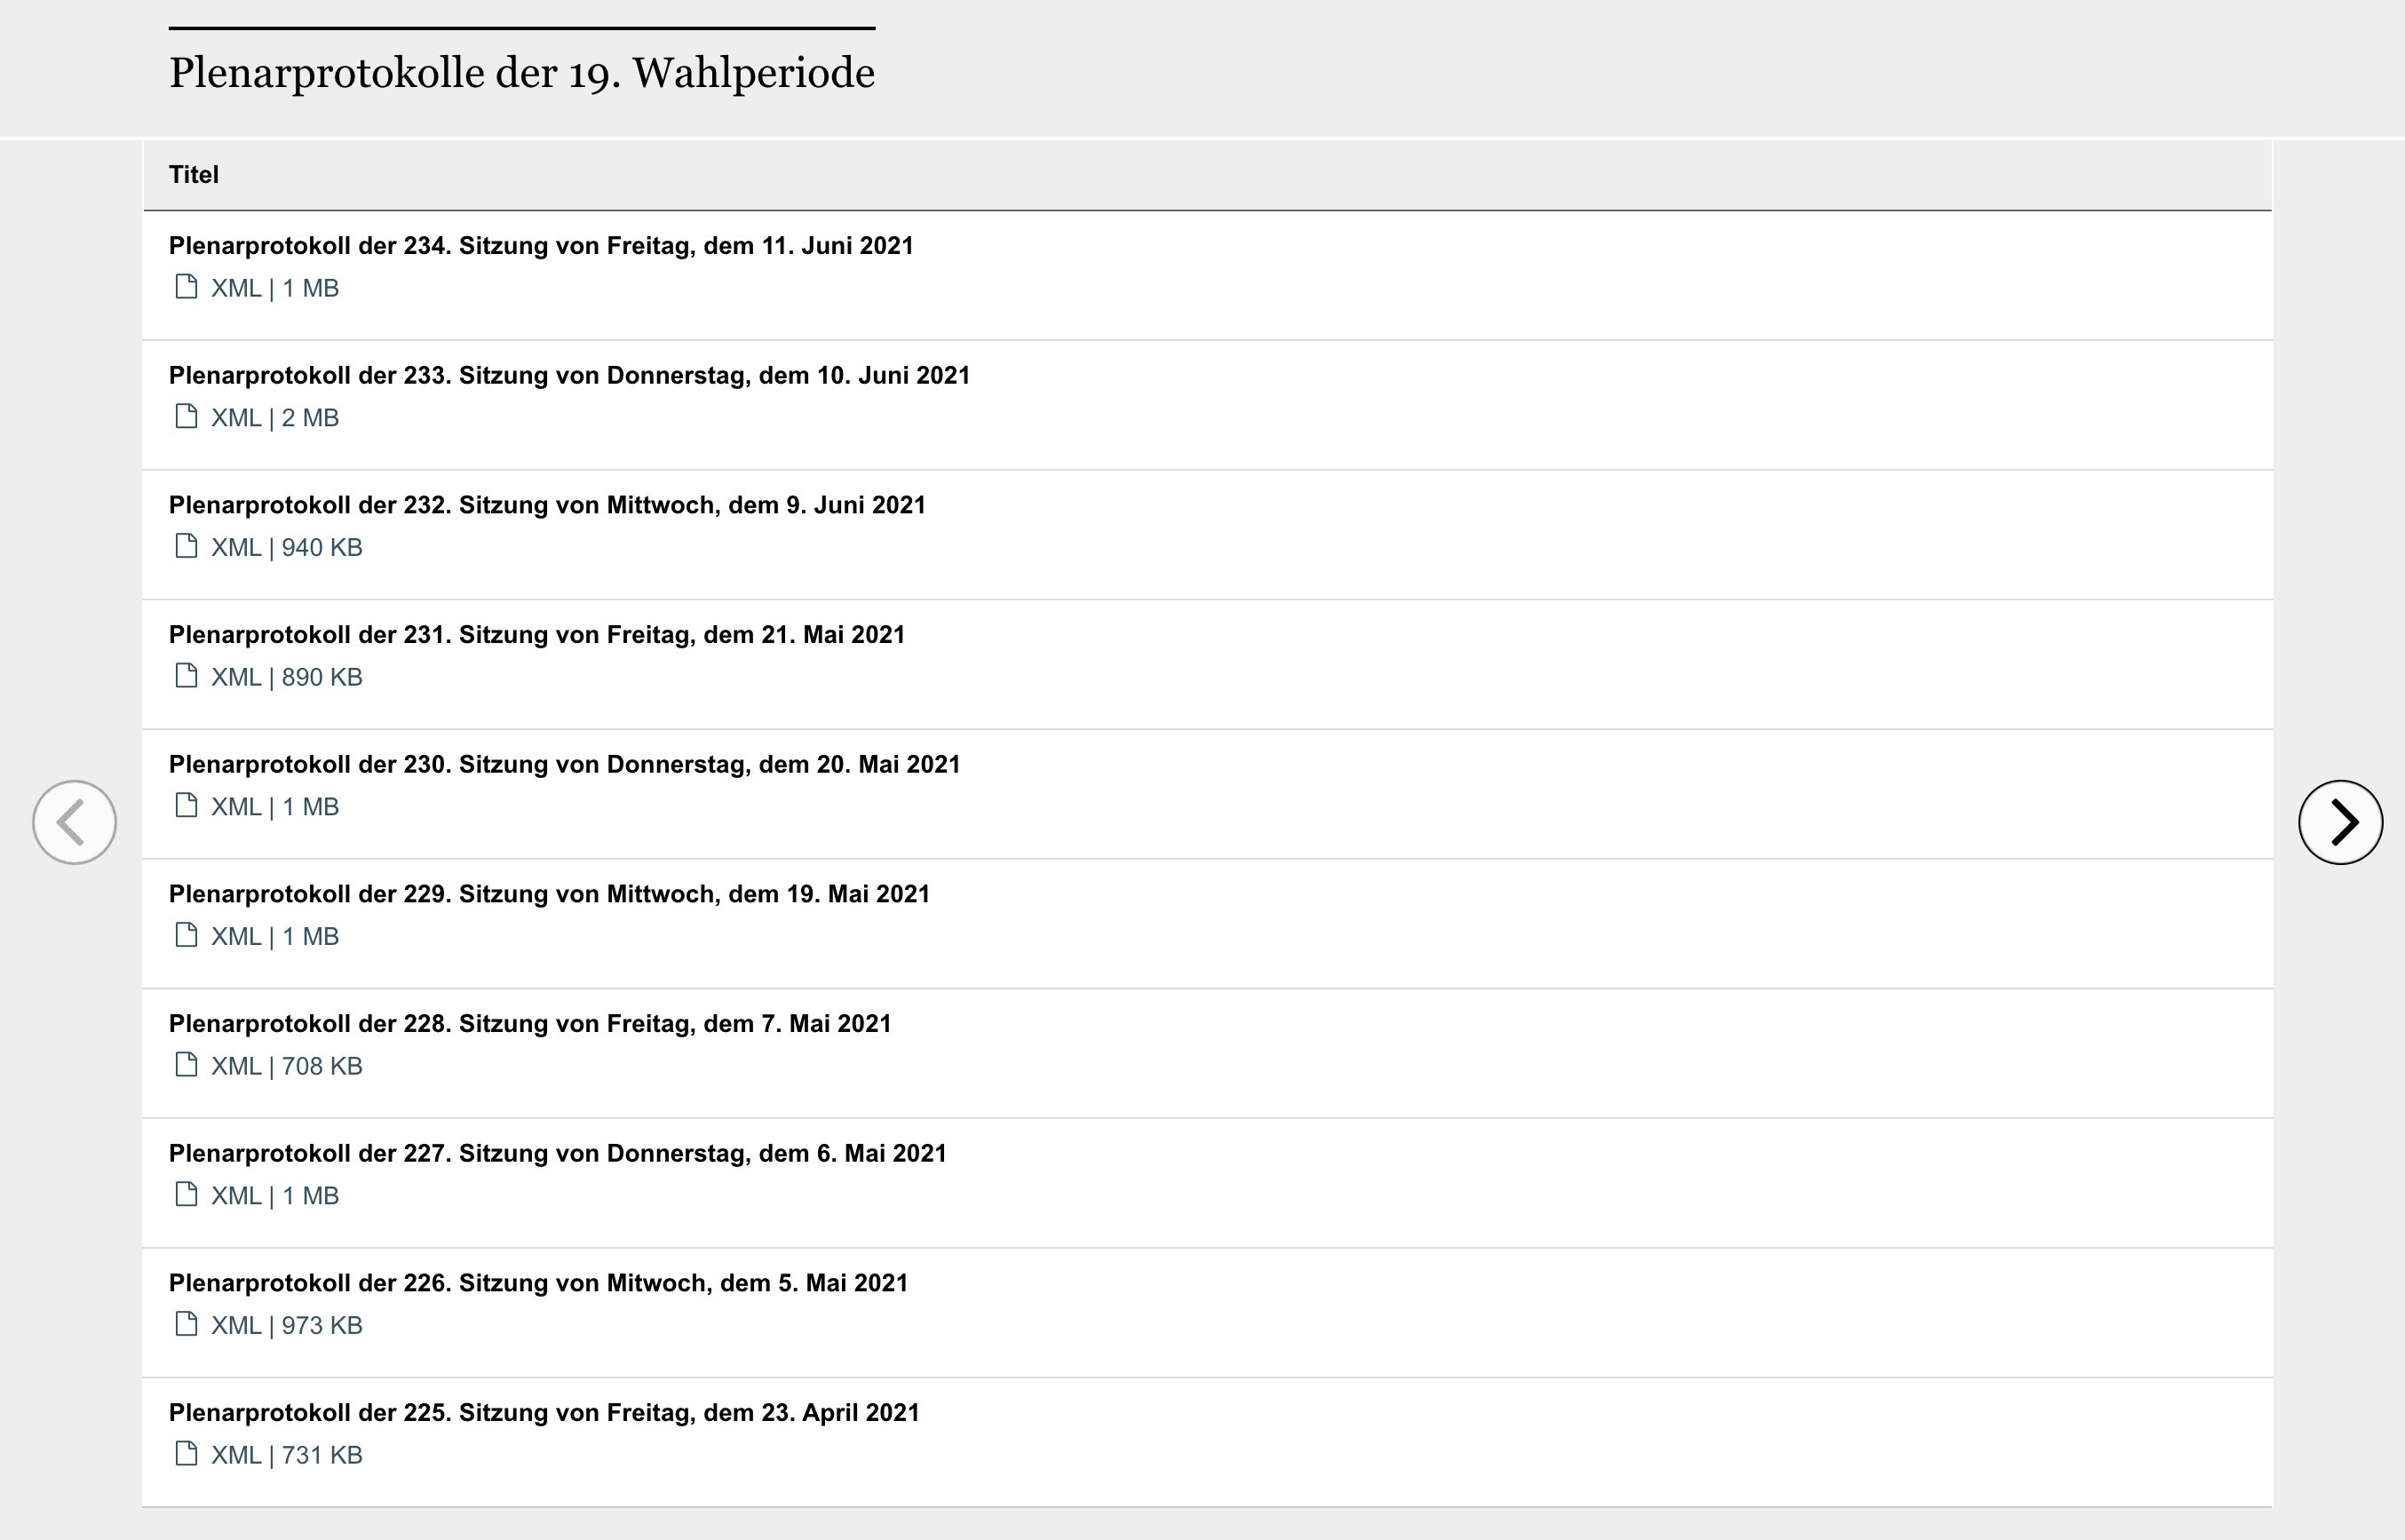

In [10]:
from bs4 import BeautifulSoup
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

def selenium_extract_urls(start_url, start_offset=10, filename="urls.txt", max_slides=20):
    """
    Extraktion der XML URLs und Speicherung in eine Datei.
    
    Parameter:
    start_url: Die URL, mit der das Crawling startet
    start_offset: Slides werden immer in 10er Gruppen angezeigt. Offset von 10 wäre also von Anfang an (default 10)
    filename: Name der Datei, wo die URLs reingeschrieben werden sollen (default 'urls.txt')
    max_slides: Maximale Anzahl der Slides, die durchsucht werden sollen. Dieser Wert kann auch 
    sehr hoch angesetzt werden, da das Programm vorzeitig abbricht, wenn man das letzte Slide erreicht(default 20)
    """
    
    def selenium_chrome():
        '''Gibt einen Webdriver zurück'''
        DRIVER_PATH = '/usr/local/bin/chromedriver' # Pfad wenn man bei OSX mit brew installiert

        options = Options()
        options.add_argument("--headless")

        driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)
        return driver

    def next_slide():
        """
        Blättert zur nächsten Slide.
        Liefert False, wenn letzte Slide erreicht wurde, sonst True
        """
        try:
            next_btn = driver.find_element_by_css_selector('div#bt-collapse-543410 button.slick-next.slick-arrow')
            if 'disabled' not in next_btn.get_attribute('class'):
                driver.execute_script("arguments[0].click();", next_btn)
                return True
            else:
                return False
        except Exception:
            return False

    def get_offset_count():
        """Ermittlung des aktuellen Offsets"""
        offset_counter_elem = driver\
            .find_element_by_css_selector('div#bt-collapse-543410 div.bt-slider.row.slick-initialized.slick-slider')
        return offset_counter_elem.get_attribute('data-currentslidecount')
     
    def extract_links():
        """Extraktion der XML-Links"""
        return [elem.get_attribute('href')
                for elem in driver.find_elements_by_css_selector("div#bt-collapse-543410 a")]
    
    def wait_for_pageload(seconds=10):
        '''
        Wartet die übergebene Anzahl an Sekunden, um ein Element zu finden, dass asnychron geladen wird. Liefert True,
        wenn gefunden und False, wenn innerhalb der angegebenen Zeit nicht gefunden.
        '''
        try:
            elements = WebDriverWait(driver, s)\
                .until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div#bt-collapse-543410 a")))
            return True
        except Exception:
            return False
        
    
    # hier geht's mit der eigentlichen Funktion los
    driver = selenium_chrome()
    
    print('Base URL:', start_url)
    
    path = '../resources/' + filename 
    
    print(f"Writing URLs to {path}")
    
    with open(path, "w", encoding="utf-8") as file:
        file.write(f"# FOUND ON {start_url}\n")
        
        url = start_url + f'?offset={start_offset}' if start_offset != 10 else start_url
        
        print('Starting crawling URL:', url)
        
        driver.get(url)
        
        if wait_for_pageload():
            print('Page fully loaded')
            slide_cnt = 0

            for slide_cnt in range(max_slides): # oder wenn letzte Seite erreicht
                time.sleep(2)
                offset = get_offset_count()
                print(f"Slide with offset {offset}")

                if not next_slide():
                    print(f"Last slide with offset {offset} - done.")
                    break
                
            links = extract_links()
            file.write("\n".join(links)+'\n')
            file.flush()
        else:
            print('Page never fully loaded, try longer waiting time in wait_for_pageload()')

    driver.quit()

In [157]:
url = 'https://www.bundestag.de/services/opendata'
selenium_extract_urls(url, max_slides=30)

https://www.bundestag.de/services/opendata
Writing URLs to urls.txt
Asynchronous tasks completed
Offset 10
Offset 20
Offset 30
Offset 40
Offset 50
Offset 60
Offset 70
Offset 80
Offset 90
Offset 100
Offset 110
Offset 120
Offset 130
Offset 140
Offset 150
Offset 160
Offset 170
Offset 180
Offset 190
Offset 200
Offset 210
Offset 220
Offset 230
Last slide with offset 230 - done.


**Info**: Die Funktion wurde im Nachhinein nochmals geändert (nur die Kommentare). Nicht wunder, dass der Output nicht zum gewünschten Output der Funktion passt.

## Download aller XML-Files mit _wget_
Alle Files in der _urls.txt_ wurden mit dem wg-tool in das Verzeichnis **crawled/** geladen. Dieses wird jedoch per .gitignore nicht mit ins git übernommen und muss selbst in ``root`` angelegt werden, falls folgender Code funktionieren soll. Der ``wget`` - Befehl muss in ``root`` ausgeführt werden.

```sh
wget -nc -i resources/urls.txt -P crawled
```

In [118]:
xml_files = glob.glob('../crawled/*')

filename = '../resources/dbt_protocols.jl'
with open(filename, 'w', encoding='utf-8') as outfile:
    for xml_file in tqdm(xml_files):
        with open(xml_file, 'r') as file:
            speeches = dbt_protocol_scraper(file.read())
        if speeches:
            for speech in speeches:
                _ = outfile.write(json.dumps(speech)+'\n')

100%|██████████| 228/228 [01:21<00:00,  2.79it/s]


## JSON in Dataframe laden

In [121]:
speeches_df = pd.read_json(filename, lines=True, encoding='utf-8')
len(speeches_df)

24647

In [126]:
speeches_df.sample(10)

,speech_id,speaker,affiliation,text,session_id,session_date,session_start,session_end,legislative_period
22037,ID1918905200,Dirk Heidenblut,SPD,"Frau Präsidentin! Meine sehr geehrten Damen und Herren! Liebe Kolleginnen und Kollegen! Ich muss quasi direkt, lieber Kollege Monstadt, auf Ihren Beitrag eingehen, weil Sie sich ausdrücklich für V...",189,05.11.2020,9:00,23:14,19
9144,ID1922203100,Anja Karliczek,Bundesministerin BMBF,"Sehr geehrte Frau Präsidentin! Liebe Kolleginnen und Kollegen! Corona hat uns allen klar und deutlich gezeigt, wie groß die Aufgaben sind, die vor uns liegen. Aber, liebe Opposition, es besteht üb...",222,16.04.2021,9:00,16:48,19
9990,ID1919605600,Helge Lindh,SPD,"Herr Präsident! Liebe Kolleginnen und Kollegen! Ist Dieter Nuhr ein Rassist? Ich überlasse es Ihnen, zu überlegen und zu entscheiden. Aber dieser aktuelle Fall sagt sehr viel darüber aus, wie wir ...",196,27.11.2020,9:00,16:16,19
20617,ID1919505800,Sabine Dittmar,SPD,"Sehr geehrter Herr Präsident! Sehr geehrte Kolleginnen und Kollegen! Ich komme wieder zurück zu dem Gesetz, das wir heute verabschieden. Damit verbessern wir in vielen Bereichen die Versorgung von...",195,26.11.2020,9:00,21:42,19
2935,ID1921001100,Georg Nüßlein,CDU/CSU,Sehr geehrter Herr Präsident! Meine Damen! Meine Herren! Nach über einem Jahr ist die Pandemie noch immer virulent; das ist die klare Überzeugung einer breiten Mehrheit in diesem Hohen Haus. Die A...,210,12.02.2021,9:00,17:01,19
21995,ID1918901000,Daniela Kluckert,FDP,"Sehr geehrter Herr Präsident! Meine Damen und Herren! Zwei Jahre Enquete-Kommission bedeuten auch zwei Jahre Kompromisse, und es ist gut, dass wir Kompromisse können. Es ist gut, dass wir im Parla...",189,05.11.2020,9:00,23:14,19
2297,ID194908800,Katrin Staffler,CDU/CSU,Frau Präsidentin! Liebe Kolleginnen und Kollegen! Sehr geehrte Damen und Herren! Wenn wir einen politisch durchschnittlich interessierten Bürger oder eine politisch durchschnittlich interessierte ...,49,13.09.2018,09:00,18:02,19
9150,ID1922203700,Elvan Korkmaz-Emre,SPD,Sehr geehrte Frau Präsidentin! Meine Damen und Herren! Die Bundesregierung betont in der Fortschreibung der KI-Strategie den Regulierungsbedarf für künstliche Intelligenz. Deshalb ist es sehr pass...,222,16.04.2021,9:00,16:48,19
22626,ID1920304100,Julia Klöckner,Bundesministerin BMEL,"Ich verstehe Ihr Ansinnen. Aber ich glaube, es ist nicht ganz redlich, in einer dynamischen Pandemie von Garantien für das ganze Jahr zu sprechen. Wir alle wissen nicht: Was passiert in welchen He...",203,13.01.2021,13:00,20:13,19
978,ID1910306900,Gerd Müller,Bundesminister BMZ,"Liebe Frau von Storch, der Kollege vom Innenministerium wird im Detail ergänzen, denke ich. Ich kann Ihnen nur sagen: Bei meinen Reisen nach Afrika, nach Nordafrika oder in andere Länder, habe ich...",103,05.06.2019,13:00,17:00,19


## Dataframe in Datenbank speichern

In [128]:
with sqlite3.connect('../resources/dbt_speeches.sqlite') as con:
    speeches_df.to_sql('speeches', con, index=False, if_exists='replace')